# Funnel Mapping and Transitions

Map user journeys through the conversion funnel and analyze drop-offs and transitions.


In [1]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

candidates = [
    r"DRIVER={ODBC Driver 17 for SQL Server};SERVER=np:\\localhost\pipe\MSSQL$SQLEXPRESS\sql\query;DATABASE=Funnel_Purchases;Trusted_Connection=yes;",
    r"DRIVER={ODBC Driver 17 for SQL Server};SERVER=(localdb)\\MSSQLLocalDB;DATABASE=Funnel_Purchases;Trusted_Connection=yes;",
    r"DRIVER={ODBC Driver 17 for SQL Server};SERVER=localhost\\SQLEXPRESS;DATABASE=Funnel_Purchases;UID=sa;PWD=YourPassword;",
]

def get_conn(timeout=30):
    for conn_str in candidates:
        try:
            conn = pyodbc.connect(conn_str, timeout=timeout)
            return conn
        except Exception:
            continue
    raise RuntimeError('All connection attempts failed')

C:\Users\asus\AppData\Local\Temp\ipykernel_5692\1918739090.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  funnel_df = pd.read_sql_query(sql_funnel, conn)


Funnel session-level counts (updated logic):
     views   carts  purchases_with_cart
0  9237562  573020               291834


C:\Users\asus\AppData\Local\Temp\ipykernel_5692\1918739090.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pct, y=stages, palette='Blues_d')


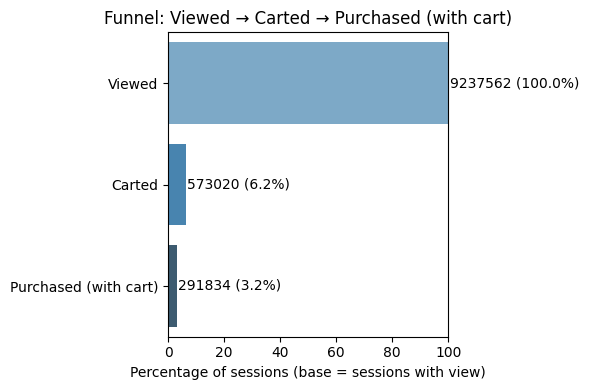

In [2]:
# --- Funnel counts per session (view -> cart -> purchase) ---
sql_funnel = """WITH session_flags AS (
  SELECT user_session,
    MAX(CASE WHEN event_type = 'view' THEN 1 ELSE 0 END) AS viewed,
    MAX(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END) AS carted,
    MAX(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) AS purchased
  FROM dbo.[2019-Oct]
  GROUP BY user_session
)
SELECT
  SUM(viewed) AS views,
  SUM(carted) AS carts,
  SUM(CASE WHEN carted = 1 AND purchased = 1 THEN 1 ELSE 0 END) AS purchases_with_cart
FROM session_flags"""
conn = get_conn()
funnel_df = pd.read_sql_query(sql_funnel, conn)
conn.close()
print('Funnel session-level counts (updated logic):')
print(funnel_df)
if not funnel_df.empty:
    counts = funnel_df.iloc[0].to_dict()
    stages = ['Viewed', 'Carted', 'Purchased (with cart)']
    vals = [counts.get('views', 0), counts.get('carts', 0), counts.get('purchases_with_cart', 0)]
    total_sessions = vals[0] if vals[0] > 0 else sum(vals)
    pct = [v / total_sessions * 100 if total_sessions>0 else 0 for v in vals]
    plt.figure(figsize=(6, 4))
    sns.barplot(x=pct, y=stages, palette='Blues_d')
    for i, v in enumerate(pct):
        plt.text(v + 0.5, i, f"{int(vals[i])} ({v:.1f}%)", va='center')
    plt.xlabel('Percentage of sessions (base = sessions with view)')
    plt.title('Funnel: Viewed → Carted → Purchased (with cart)')
    plt.xlim(0, 100)
    plt.tight_layout()
    plt.show()

C:\Users\asus\AppData\Local\Temp\ipykernel_5692\3063824372.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  trans = pd.read_sql_query(sql_transitions, conn)


Consecutive event transitions (sample):
  from_type   to_type       cnt
0      view      cart    740181
1      cart      cart    180690
2      cart  purchase    312359
3  purchase      cart      2340
4      cart      view    335376
5      view      view  30692105
6      view  purchase    428300
7  purchase  purchase       894
8  purchase      view    448443


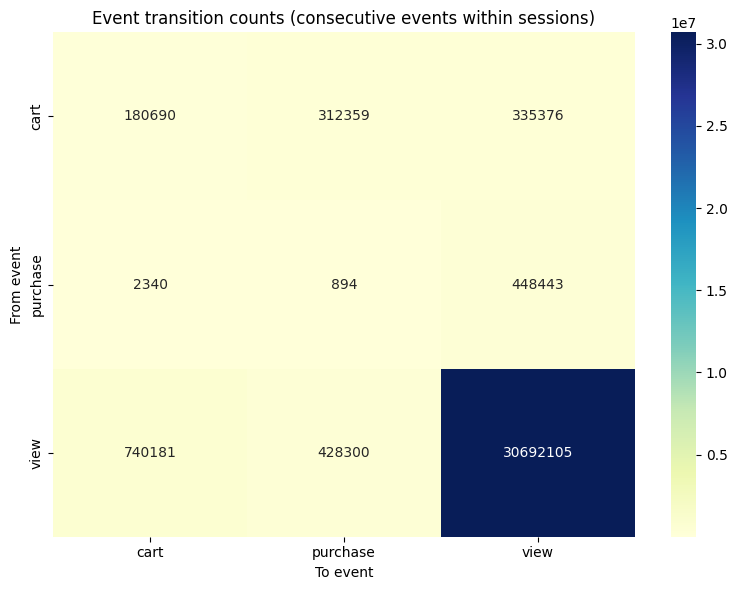

In [3]:
# --- Transition counts (pairwise consecutive event transitions) and heatmap ---
sql_transitions = """WITH seq AS (
  SELECT user_session, event_time, event_type, ROW_NUMBER() OVER (PARTITION BY user_session ORDER BY event_time) AS rn
  FROM dbo.[2019-Oct]
),
pairs AS (
  SELECT s1.event_type AS from_type, s2.event_type AS to_type, COUNT(*) AS cnt
  FROM seq s1
  JOIN seq s2 ON s1.user_session = s2.user_session AND s1.rn + 1 = s2.rn
  GROUP BY s1.event_type, s2.event_type
)
SELECT * FROM pairs"""
conn = get_conn()
trans = pd.read_sql_query(sql_transitions, conn)
conn.close()
print('Consecutive event transitions (sample):')
print(trans.head(20))
if not trans.empty:
    pivot = trans.pivot(index='from_type', columns='to_type', values='cnt').fillna(0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, annot=True, fmt='.0f', cmap='YlGnBu')
    plt.title('Event transition counts (consecutive events within sessions)')
    plt.xlabel('To event')
    plt.ylabel('From event')
    plt.tight_layout()
    plt.show()

## Optimization Note

- Funnel and transition queries select only required columns.
- Use chunked loading for large session tables.
- Example: `SELECT user_session, event_type, event_time FROM dbo.[2019-Oct]`
